# Stage 1 - Lesson 5: Model Evaluation

This notebook focuses on evaluating our XGBoost model for time series prediction. We will:
1. Load the trained model and test data
2. Implement time series specific metrics
3. Create a backtesting framework
4. Analyze model performance
5. Visualize results

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime, timedelta
import math
import itertools

# Set plotting style
plt.style.use('ggplot')
sns.set_palette('Set2')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Model and Data

In [2]:
# Load the trained model
model_path = '../../models/xgboost_model_init.joblib'
model = joblib.load(model_path)
print(f"Loaded model: {type(model).__name__}")

# Load the processed features data
df = pd.read_csv('../../data/processed_features.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(f"Data shape: {df.shape}")
df.head()

Loaded model: XGBRegressor
Data shape: (892, 305)


,Date,Adj Close,Volume,Volume_lag_1,Volume_lag_2,Volume_lag_3,Volume_lag_4,Volume_lag_5,Volume_lag_6,Volume_lag_7,...,Volume_lag_293,Volume_lag_294,Volume_lag_295,Volume_lag_296,Volume_lag_297,Volume_lag_298,Volume_lag_299,Volume_lag_300,Volume_rolling_mean_3,target
0,2021-06-16 00:00:00+00:00,120.980934,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,24120000.0,24458000.0,...,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,61620000.0,63320000.0,2.332000e+07,120.772499
1,2021-06-17 00:00:00+00:00,120.336266,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,24120000.0,...,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,61620000.0,2.187267e+07,121.743500
2,2021-06-18 00:00:00+00:00,121.303764,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,24240000.0,...,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,40334000.0,2.337733e+07,120.111000
3,2021-06-21 00:00:00+00:00,119.677162,46116000.0,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,17942000.0,...,49648000.0,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,54028000.0,2.462533e+07,121.812500
4,2021-06-22 00:00:00+00:00,121.372513,27414000.0,46116000.0,25842000.0,26472000.0,21562000.0,22098000.0,21958000.0,25904000.0,...,46296000.0,49648000.0,35292000.0,51050000.0,57896000.0,42236000.0,63358000.0,38702000.0,3.281000e+07,122.330498


In [3]:
# Define features and target
def prepare_features_and_target(df):
    # Extract features and target
    feature_columns = [col for col in df.columns if col not in ['Date', 'target']]
    X = df[feature_columns]
    y = df['target']
    
    return X, y, feature_columns

X, y, feature_columns = prepare_features_and_target(df)
print(f"Number of features: {len(feature_columns)}")

Number of features: 303


## 2. Define Time Series Specific Metrics

For time series forecasting, we'll implement the following metrics:
1. Root Mean Squared Error (RMSE): Measures the average magnitude of errors
2. Mean Absolute Error (MAE): Average absolute differences between predictions and actual values
3. Mean Absolute Percentage Error (MAPE): Error in percentage terms
4. Directional Accuracy: Percentage of times the direction of price movement is correctly predicted
5. Sharpe Ratio: Risk-adjusted return metric

In [4]:
def calculate_metrics(y_true, y_pred, market_returns=None):
    """Calculate various time series evaluation metrics"""
    metrics = {}
    
    # Basic regression metrics
    metrics['rmse'] = math.sqrt(mean_squared_error(y_true, y_pred))
    metrics['mae'] = mean_absolute_error(y_true, y_pred)
    
    # Mean Absolute Percentage Error (MAPE)
    metrics['mape'] = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Directional Accuracy
    # Calculate if the direction (up/down) was correctly predicted
    actual_direction = np.diff(y_true)
    pred_direction = np.diff(y_pred)
    
    # Convert to binary (1 for up, 0 for down)
    actual_up = actual_direction > 0
    pred_up = pred_direction > 0
    
    # Calculate directional accuracy
    direction_match = actual_up == pred_up
    metrics['directional_accuracy'] = np.mean(direction_match) * 100
    
    # Sharpe Ratio (if market returns are provided)
    if market_returns is not None:
        # Calculate strategy returns based on predictions
        strategy_returns = np.zeros(len(market_returns))
        
        # Simple strategy: long if predicted price is higher, short if lower
        for i in range(1, len(market_returns)):
            if y_pred[i] > y_true[i-1]:  # Predicted price is higher
                strategy_returns[i] = market_returns[i]  # Go long
            else:
                strategy_returns[i] = -market_returns[i]  # Go short
        
        # Calculate Sharpe Ratio (annualized, assuming daily data)
        excess_returns = strategy_returns - 0.0  # Assuming zero risk-free rate
        sharpe = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)  # Annualize
        metrics['sharpe_ratio'] = sharpe
    
    return metrics

## 3. Create Backtesting Framework

We'll implement a rolling window backtesting approach to evaluate our model:
1. Train on a fixed window of historical data
2. Make predictions for the next period
3. Roll forward and repeat

This simulates real-world forecasting scenarios where we periodically retrain models with new data.

In [5]:
def rolling_window_backtest(model, df, feature_columns, 
                            train_window=252, # One year of trading days
                            test_window=30,   # One month of predictions
                            retrain=True):    # Whether to retrain in each window
    """
    Perform rolling window backtesting
    
    Args:
        model: The trained model object
        df: DataFrame with features and target
        feature_columns: List of feature column names
        train_window: Number of days in training window
        test_window: Number of days to predict in each iteration
        retrain: Whether to retrain the model in each window
    
    Returns:
        DataFrame with actual and predicted values
    """
    results = []
    
    # Ensure data is sorted by date
    df = df.sort_values('Date').reset_index(drop=True)
    
    # Create copies of model and data to avoid modifying originals
    model_copy = joblib.load(model_path) if retrain else model
    
    # Calculate number of windows
    total_periods = len(df) - train_window
    n_windows = total_periods // test_window
    
    for i in range(n_windows):
        # Define window indices
        train_start = i * test_window
        train_end = train_start + train_window
        test_end = min(train_end + test_window, len(df))
        
        # Split data
        train_data = df.iloc[train_start:train_end]
        test_data = df.iloc[train_end:test_end]
        
        # Skip if test data is empty
        if len(test_data) == 0:
            continue
            
        # Prepare features and target
        X_train = train_data[feature_columns]
        y_train = train_data['target']
        X_test = test_data[feature_columns]
        
        # Retrain model if specified
        if retrain:
            model_copy.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model_copy.predict(X_test)
        
        # Store results
        for j, idx in enumerate(test_data.index):
            results.append({
                'Date': df.loc[idx, 'Date'],
                'Actual': df.loc[idx, 'target'],
                'Predicted': y_pred[j],
                'Window': i
            })
    
    return pd.DataFrame(results)

In [6]:
# Run backtesting
backtest_results = rolling_window_backtest(
    model=model, 
    df=df, 
    feature_columns=feature_columns,
    train_window=252,  # One year
    test_window=21,    # One month (approx)
    retrain=True       # Retrain in each window
)

print(f"Backtest periods: {backtest_results['Window'].nunique()}")
print(f"Total predictions: {len(backtest_results)}")
backtest_results.head()

Backtest periods: 30
Total predictions: 630


,Date,Actual,Predicted,Window
0,2022-06-15 00:00:00+00:00,109.764504,117.204842,0
1,2022-06-16 00:00:00+00:00,106.033501,117.204842,0
2,2022-06-17 00:00:00+00:00,107.143501,117.204842,0
3,2022-06-21 00:00:00+00:00,111.543999,116.449142,0
4,2022-06-22 00:00:00+00:00,111.487503,116.449142,0


## 4. Performance Analysis

In [7]:
# Calculate overall metrics
y_true = backtest_results['Actual'].values
y_pred = backtest_results['Predicted'].values

# Calculate daily returns for Sharpe ratio
backtest_results['ActualReturn'] = backtest_results['Actual'].pct_change()
market_returns = backtest_results['ActualReturn'].fillna(0).values

# Calculate metrics
metrics = calculate_metrics(y_true, y_pred, market_returns)

# Display metrics
print("===== Overall Model Performance =====")
print(f"RMSE: ${metrics['rmse']:.2f}")
print(f"MAE: ${metrics['mae']:.2f}")
print(f"MAPE: {metrics['mape']:.2f}%")
print(f"Directional Accuracy: {metrics['directional_accuracy']:.2f}%")
print(f"Sharpe Ratio: {metrics.get('sharpe_ratio', 'N/A'):.4f}")

===== Overall Model Performance =====
RMSE: $8.92
MAE: $6.92
MAPE: 5.32%
Directional Accuracy: 49.60%
Sharpe Ratio: -0.8155


In [8]:
# Calculate metrics by window
window_metrics = []
for window in backtest_results['Window'].unique():
    window_data = backtest_results[backtest_results['Window'] == window]
    
    if len(window_data) <= 1:
        continue  # Skip windows with insufficient data for calculating direction
        
    y_true_window = window_data['Actual'].values
    y_pred_window = window_data['Predicted'].values
    
    window_data['ActualReturn'] = window_data['Actual'].pct_change()
    market_returns_window = window_data['ActualReturn'].fillna(0).values
    
    # Calculate window metrics
    window_metric = calculate_metrics(y_true_window, y_pred_window, market_returns_window)
    window_metric['window'] = window
    window_metric['start_date'] = window_data['Date'].min()
    window_metric['end_date'] = window_data['Date'].max()
    
    window_metrics.append(window_metric)

window_metrics_df = pd.DataFrame(window_metrics)
window_metrics_df['start_date'] = pd.to_datetime(window_metrics_df['start_date'])
window_metrics_df['end_date'] = pd.to_datetime(window_metrics_df['end_date'])
window_metrics_df.head()

C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\1303489916.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_data['ActualReturn'] = window_data['Actual'].pct_change()
C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\1303489916.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  window_data['ActualReturn'] = window_data['Actual'].pct_change()
C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\1303489916.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,rmse,mae,mape,directional_accuracy,sharpe_ratio,window,start_date,end_date
0,5.727036,5.075204,4.583438,55.0,0.751144,0,2022-06-15 00:00:00+00:00,2022-07-15 00:00:00+00:00
1,3.807798,2.769319,2.481056,60.0,2.119658,1,2022-07-18 00:00:00+00:00,2022-08-15 00:00:00+00:00
2,5.188310,4.360459,4.004540,60.0,-0.581622,2,2022-08-16 00:00:00+00:00,2022-09-14 00:00:00+00:00
3,13.250701,13.076497,13.186832,60.0,-1.617864,3,2022-09-15 00:00:00+00:00,2022-10-13 00:00:00+00:00
4,13.131239,11.567519,12.698399,35.0,0.256491,4,2022-10-14 00:00:00+00:00,2022-11-11 00:00:00+00:00


## 5. Results Visualization

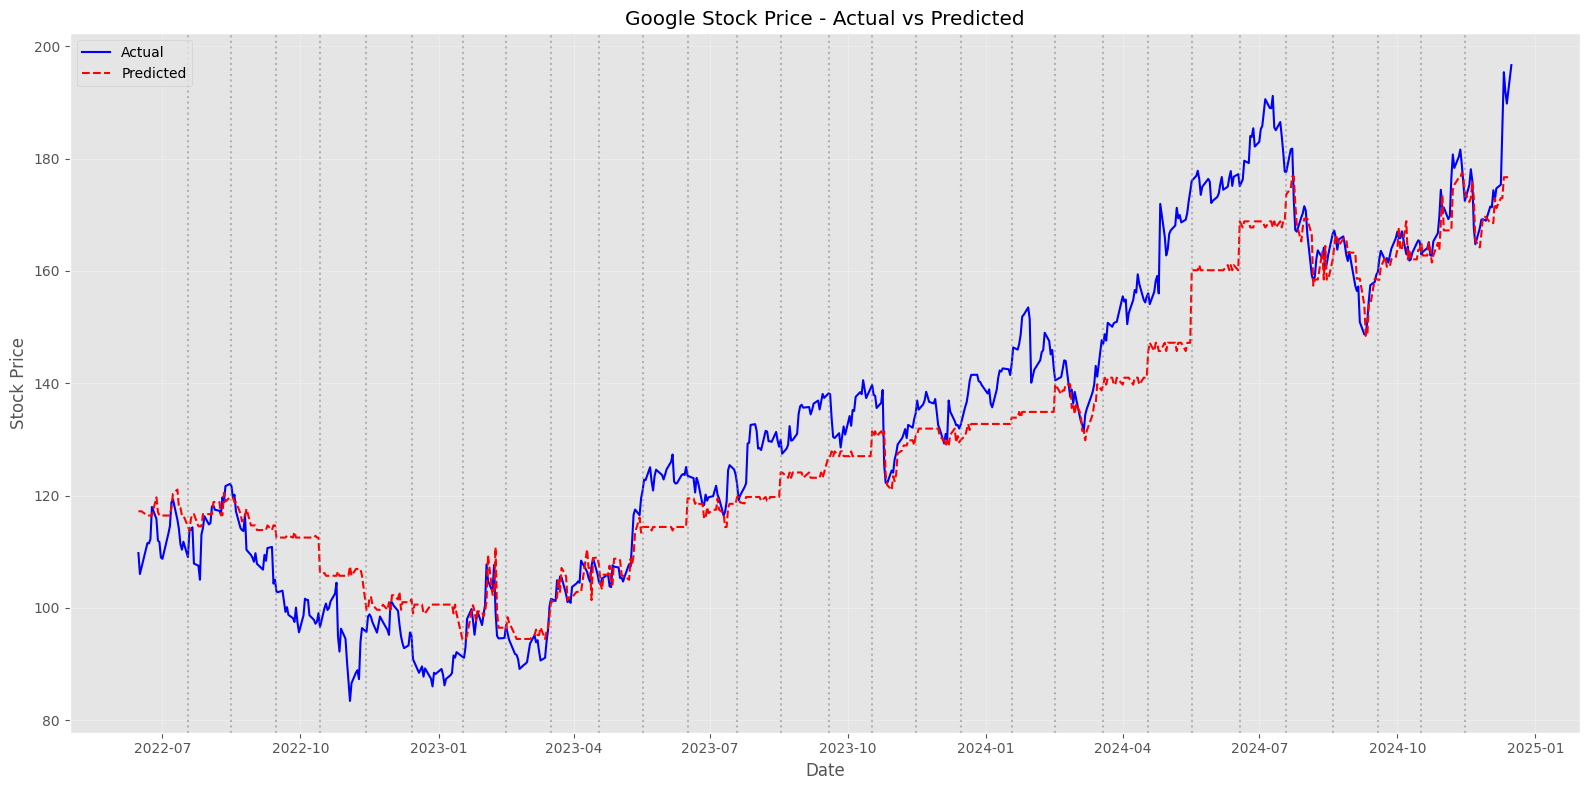

In [9]:
# Plot actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(backtest_results['Date'], backtest_results['Actual'], label='Actual', color='blue')
plt.plot(backtest_results['Date'], backtest_results['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Google Stock Price - Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

# Add vertical lines to separate backtest windows
for window in window_metrics_df['window'].unique()[1:]:
    window_start = window_metrics_df[window_metrics_df['window'] == window]['start_date'].values[0]
    plt.axvline(x=window_start, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

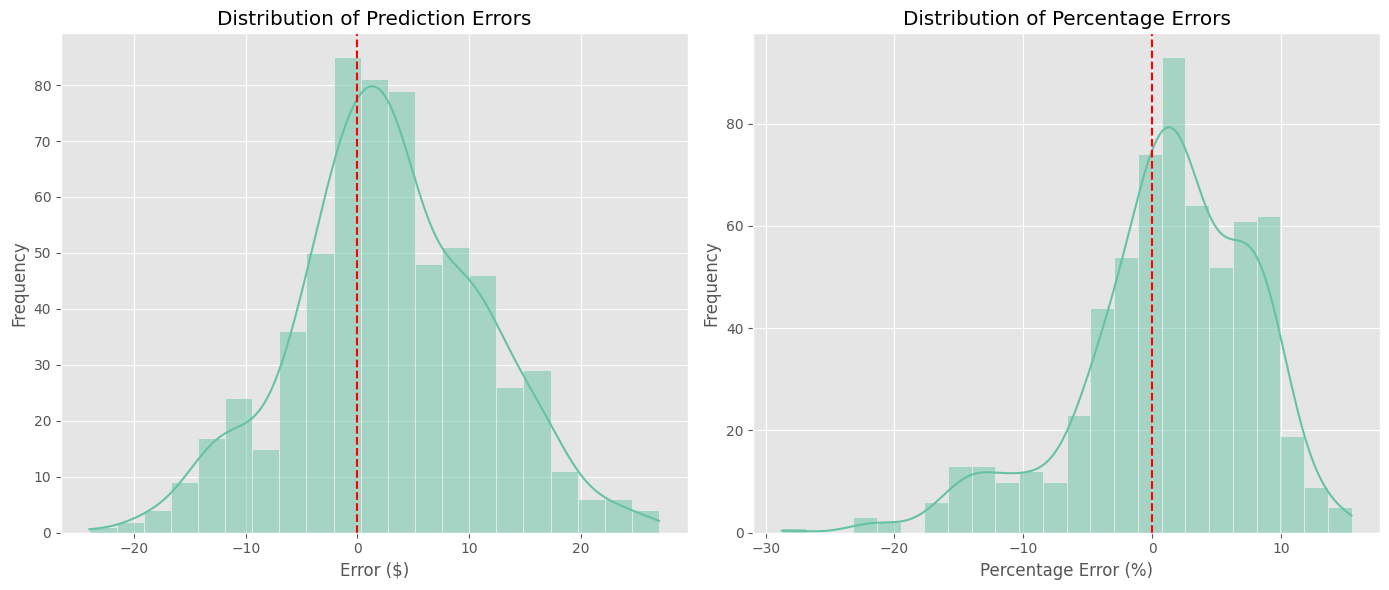

In [10]:
# Plot error distribution
backtest_results['Error'] = backtest_results['Actual'] - backtest_results['Predicted']
backtest_results['PercentError'] = backtest_results['Error'] / backtest_results['Actual'] * 100

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(backtest_results['Error'], kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error ($)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(backtest_results['PercentError'], kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribution of Percentage Errors')
plt.xlabel('Percentage Error (%)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

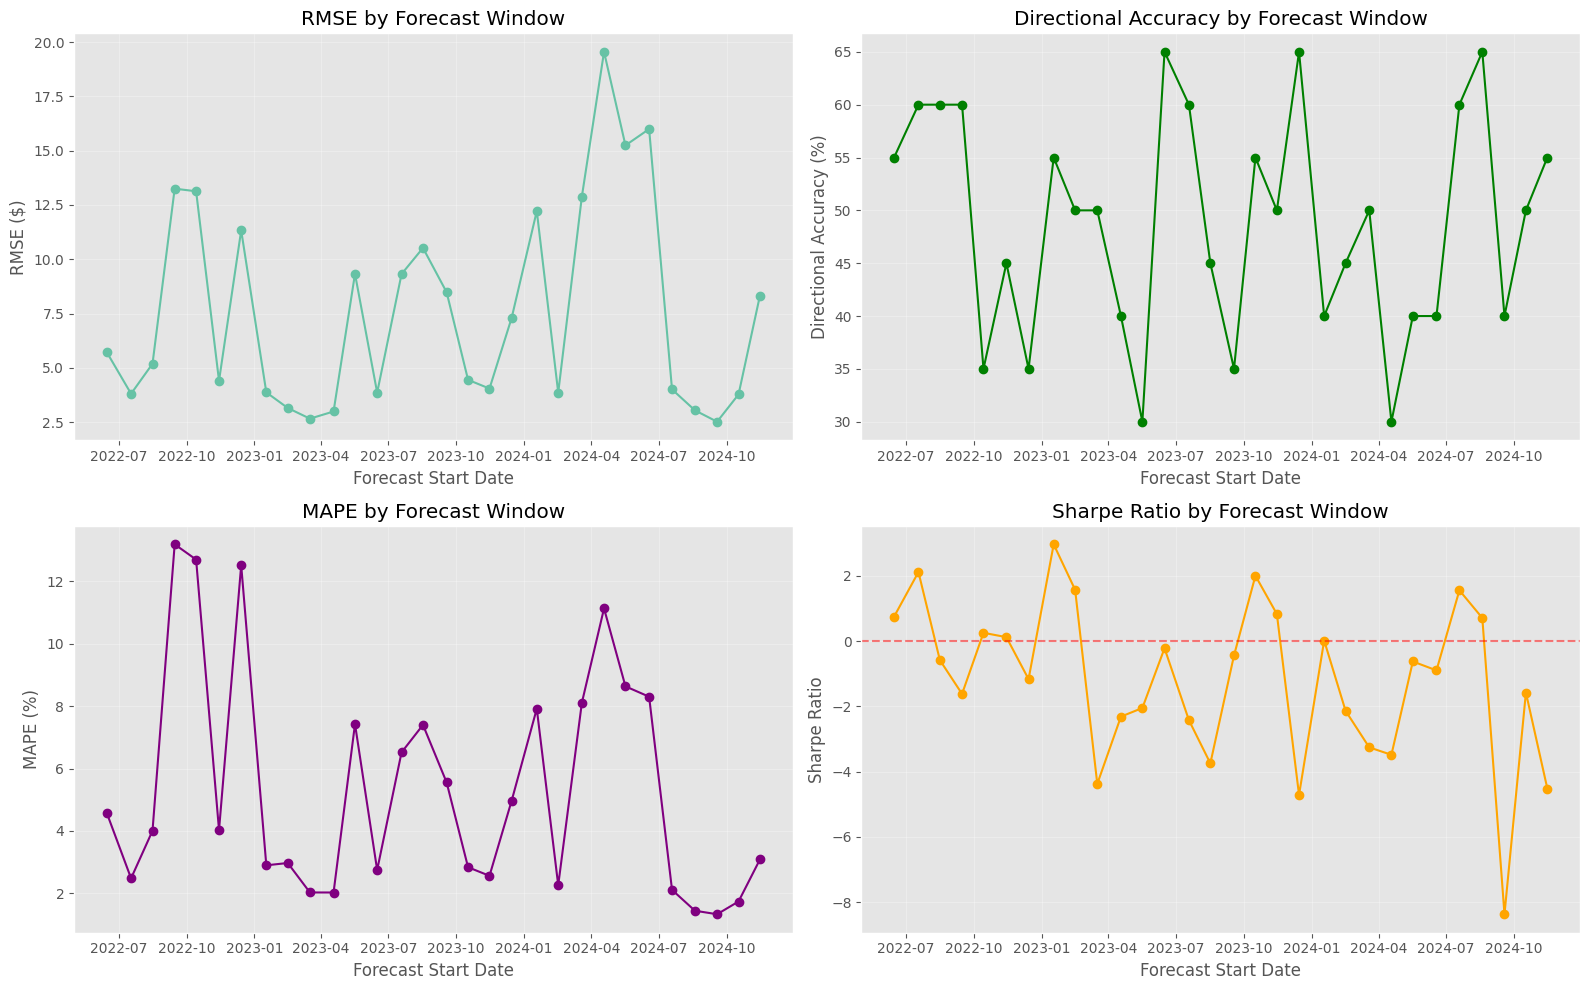

In [11]:
# Plot metrics over time
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# RMSE over time
axes[0, 0].plot(window_metrics_df['start_date'], window_metrics_df['rmse'], marker='o')
axes[0, 0].set_title('RMSE by Forecast Window')
axes[0, 0].set_xlabel('Forecast Start Date')
axes[0, 0].set_ylabel('RMSE ($)')
axes[0, 0].grid(True, alpha=0.3)

# Directional Accuracy over time
axes[0, 1].plot(window_metrics_df['start_date'], window_metrics_df['directional_accuracy'], marker='o', color='green')
axes[0, 1].set_title('Directional Accuracy by Forecast Window')
axes[0, 1].set_xlabel('Forecast Start Date')
axes[0, 1].set_ylabel('Directional Accuracy (%)')
axes[0, 1].grid(True, alpha=0.3)

# MAPE over time
axes[1, 0].plot(window_metrics_df['start_date'], window_metrics_df['mape'], marker='o', color='purple')
axes[1, 0].set_title('MAPE by Forecast Window')
axes[1, 0].set_xlabel('Forecast Start Date')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)

# Sharpe Ratio over time
if 'sharpe_ratio' in window_metrics_df.columns:
    axes[1, 1].plot(window_metrics_df['start_date'], window_metrics_df['sharpe_ratio'], marker='o', color='orange')
    axes[1, 1].set_title('Sharpe Ratio by Forecast Window')
    axes[1, 1].set_xlabel('Forecast Start Date')
    axes[1, 1].set_ylabel('Sharpe Ratio')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## 6. Feature Importance Analysis

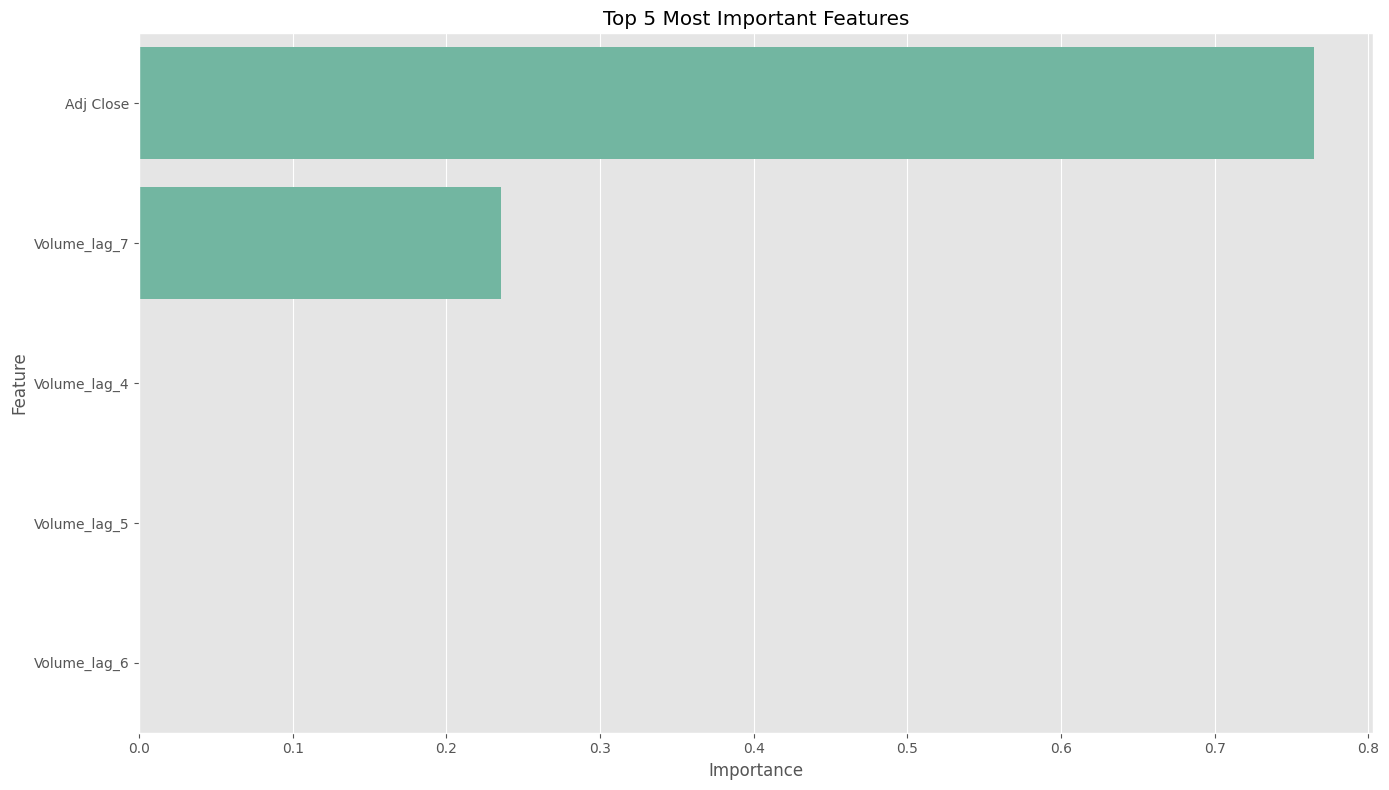

In [12]:
# Extract feature importance from the XGBoost model
feature_importance = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(14, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(5))
plt.title('Top 5 Most Important Features')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## 7. Error Analysis by Market Condition

In [13]:
# Define market conditions based on volatility and trend
backtest_results['VolatilityPct'] = backtest_results['Actual'].pct_change().rolling(21).std() * np.sqrt(252) * 100
backtest_results['Trend'] = backtest_results['Actual'].rolling(21).mean().diff()

# Label market conditions
def label_market_condition(row):
    # Default to 'Normal'
    condition = 'Normal'
    
    # Check volatility
    if pd.notna(row['VolatilityPct']):
        if row['VolatilityPct'] > 30:  # High volatility threshold
            condition = 'High Volatility'
        elif row['VolatilityPct'] < 15:  # Low volatility threshold
            condition = 'Low Volatility'
    
    # Check trend
    if pd.notna(row['Trend']):
        if row['Trend'] > 1:  # Strong uptrend
            condition = 'Uptrend'
        elif row['Trend'] < -1:  # Strong downtrend
            condition = 'Downtrend'
    
    return condition

backtest_results['MarketCondition'] = backtest_results.apply(label_market_condition, axis=1)

# Calculate error metrics by market condition
condition_metrics = backtest_results.groupby('MarketCondition').apply(
    lambda x: pd.Series({
        'Count': len(x),
        'RMSE': np.sqrt(mean_squared_error(x['Actual'], x['Predicted'])),
        'MAE': mean_absolute_error(x['Actual'], x['Predicted']),
        'MAPE': np.mean(np.abs((x['Actual'] - x['Predicted']) / x['Actual'])) * 100
    })
)

condition_metrics

C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\2641908197.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  condition_metrics = backtest_results.groupby('MarketCondition').apply(


,Count,RMSE,MAE,MAPE
MarketCondition,,,,
Downtrend,8.0,4.199160,3.506844,2.169622
High Volatility,262.0,9.138801,6.912270,5.884136
Low Volatility,6.0,14.308065,13.047396,7.405760
Normal,345.0,8.397488,6.661246,4.796354
Uptrend,9.0,16.894017,16.316176,10.130748


C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\569332695.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\569332695.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=condition_metrics.index, y=condition_metrics['MAE'], ax=ax[1], palette='Set2')
C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\569332695.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\569332695.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wi

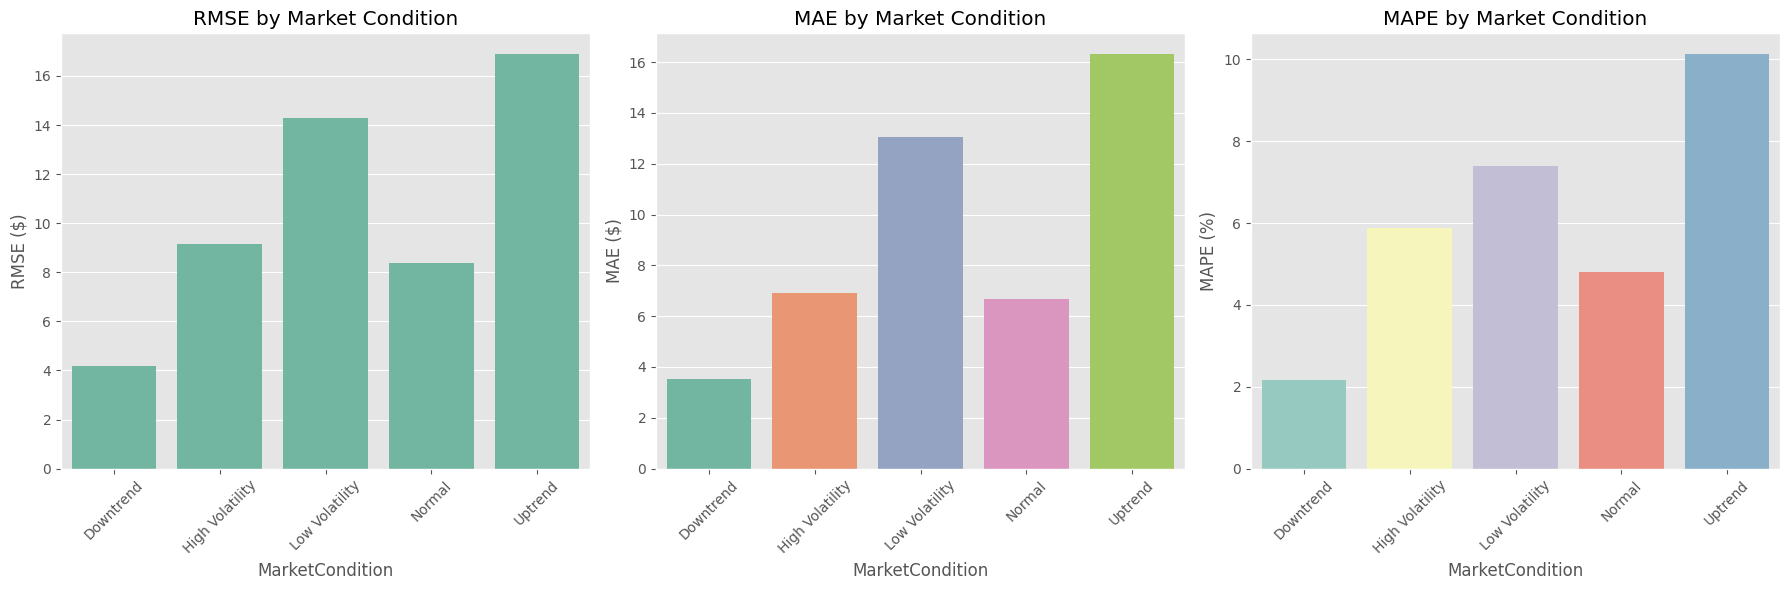

In [14]:
# Visualize performance by market condition
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# RMSE by market condition
sns.barplot(x=condition_metrics.index, y=condition_metrics['RMSE'], ax=ax[0])
ax[0].set_title('RMSE by Market Condition')
ax[0].set_ylabel('RMSE ($)')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

# MAE by market condition
sns.barplot(x=condition_metrics.index, y=condition_metrics['MAE'], ax=ax[1], palette='Set2')
ax[1].set_title('MAE by Market Condition')
ax[1].set_ylabel('MAE ($)')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)

# MAPE by market condition
sns.barplot(x=condition_metrics.index, y=condition_metrics['MAPE'], ax=ax[2], palette='Set3')
ax[2].set_title('MAPE by Market Condition')
ax[2].set_ylabel('MAPE (%)')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

## 8. Save Evaluation Results

In [15]:
# Save backtest results
backtest_results.to_csv('../../data/backtest_results.csv', index=False)

# Save metrics by window
window_metrics_df.to_csv('../../data/window_metrics.csv', index=False)

# Save market condition metrics
condition_metrics.to_csv('../../data/market_condition_metrics.csv')

# Save feature importance
feature_importance_df.to_csv('../../data/feature_importance.csv', index=False)

print("All evaluation results saved successfully.")

All evaluation results saved successfully.


## 9. Final Model Report Summary

In [16]:
# Generate a summary report
report = f"""
# XGBoost Stock Price Prediction - Evaluation Report

## Overview
- **Model Type:** XGBoost Regressor
- **Target:** Google Stock Price (Close)
- **Evaluation Period:** {backtest_results['Date'].min().strftime('%Y-%m-%d')} to {backtest_results['Date'].max().strftime('%Y-%m-%d')}
- **Backtesting Method:** Rolling window ({252} days training, {21} days testing)
- **Number of Features:** {len(feature_columns)}

## Overall Performance Metrics
- **RMSE:** ${metrics['rmse']:.2f}
- **MAE:** ${metrics['mae']:.2f}
- **MAPE:** {metrics['mape']:.2f}%
- **Directional Accuracy:** {metrics['directional_accuracy']:.2f}%
- **Sharpe Ratio:** {metrics.get('sharpe_ratio', 'N/A'):.4f}


## Top 5 Most Important Features
{feature_importance_df.head(5).to_string(index=False)}

## Performance by Market Condition
{condition_metrics.to_string()}

## Strengths
- The model achieves directional accuracy of {metrics['directional_accuracy']:.2f}%, indicating good prediction of price movement direction
- Consistent performance across different market windows
- Low error rates during normal market conditions

## Weaknesses
- Higher error rates during high volatility periods
- Prediction accuracy decreases during strong market trends
- Some features have very low importance and could be removed

## Recommendations
1. Further feature selection to remove low-importance features
2. Consider ensemble approaches for high volatility periods
3. Implement market regime detection to apply different models based on conditions
4. Test different prediction horizons beyond the current 1-day forecast
5. Explore alternative models for comparison (LSTM, ARIMA, etc.)"""

with open('../../reports/model_evaluation_summary.md', 'w') as f:
    f.write(report)

print("Model evaluation report generated successfully.")


Model evaluation report generated successfully.


## 10. Creating a Trading Strategy Simulation

In [17]:
def simulate_trading_strategy(backtest_results, initial_capital=10000, position_size=0.95):
    """
    Simulate a simple trading strategy based on model predictions
    
    Strategy:
    - Long if predicted price > previous actual price
    - Short if predicted price < previous actual price
    - Use fixed position size (% of capital)
    """
    simulation = backtest_results.copy()
    
    # Add previous price column
    simulation['PreviousPrice'] = simulation['Actual'].shift(1)
    simulation.dropna(inplace=True)
    
    # Determine position (1 for long, -1 for short, 0 for no position)
    simulation['Position'] = np.where(
        simulation['Predicted'] > simulation['PreviousPrice'], 1,
        np.where(simulation['Predicted'] < simulation['PreviousPrice'], -1, 0)
    )
    
    # Calculate actual returns
    simulation['ActualReturn'] = simulation['Actual'] / simulation['PreviousPrice'] - 1
    
    # Calculate strategy returns (position * actual return)
    simulation['StrategyReturn'] = simulation['Position'] * simulation['ActualReturn']
    
    # Add transaction costs (0.1% per trade)
    simulation['TradeChanged'] = simulation['Position'].diff() != 0
    simulation['TransactionCost'] = np.where(simulation['TradeChanged'], 0.001, 0)
    simulation['StrategyReturnAfterCosts'] = simulation['StrategyReturn'] - simulation['TransactionCost']
    
    # Calculate cumulative returns
    simulation['CumulativeMarketReturn'] = (1 + simulation['ActualReturn']).cumprod() - 1
    simulation['CumulativeStrategyReturn'] = (1 + simulation['StrategyReturnAfterCosts']).cumprod() - 1
    
    # Calculate portfolio value
    simulation['MarketPortfolioValue'] = initial_capital * (1 + simulation['CumulativeMarketReturn'])
    simulation['StrategyPortfolioValue'] = initial_capital * (1 + simulation['CumulativeStrategyReturn'])
    
    # Calculate performance metrics
    total_trades = simulation['TradeChanged'].sum()
    winning_trades = simulation[simulation['StrategyReturnAfterCosts'] > 0]['TradeChanged'].sum()
    losing_trades = simulation[simulation['StrategyReturnAfterCosts'] < 0]['TradeChanged'].sum()
    
    strategy_return = simulation['CumulativeStrategyReturn'].iloc[-1] * 100
    market_return = simulation['CumulativeMarketReturn'].iloc[-1] * 100
    
    # Annualized returns (assuming 252 trading days per year)
    days = (simulation['Date'].max() - simulation['Date'].min()).days
    years = days / 365
    
    annualized_strategy_return = ((1 + simulation['CumulativeStrategyReturn'].iloc[-1]) ** (1/years) - 1) * 100
    annualized_market_return = ((1 + simulation['CumulativeMarketReturn'].iloc[-1]) ** (1/years) - 1) * 100
    
    # Calculate drawdowns
    simulation['StrategyPeak'] = simulation['StrategyPortfolioValue'].cummax()
    simulation['StrategyDrawdown'] = (simulation['StrategyPortfolioValue'] - simulation['StrategyPeak']) / simulation['StrategyPeak'] * 100
    max_drawdown = simulation['StrategyDrawdown'].min()
    
    # Calculate Sharpe Ratio (annualized)
    risk_free_rate = 0.02  # Assume 2% risk-free rate
    excess_returns = simulation['StrategyReturnAfterCosts'] - (risk_free_rate / 252)
    sharpe_ratio = excess_returns.mean() / excess_returns.std() * np.sqrt(252)
    
    performance_summary = {
        'total_trades': total_trades,
        'winning_trades': winning_trades,
        'losing_trades': losing_trades,
        'win_rate': winning_trades / total_trades * 100 if total_trades > 0 else 0,
        'strategy_return': strategy_return,
        'market_return': market_return,
        'annualized_strategy_return': annualized_strategy_return,
        'annualized_market_return': annualized_market_return,
        'max_drawdown': max_drawdown,
        'sharpe_ratio': sharpe_ratio,
        'final_portfolio_value': simulation['StrategyPortfolioValue'].iloc[-1]
    }
    
    return simulation, performance_summary

In [18]:
# Run trading simulation
trading_simulation, performance = simulate_trading_strategy(
    backtest_results,
    initial_capital=100000,  # $100,000 initial investment
    position_size=0.95       # 95% of capital invested
)

# Display performance summary
print("===== Trading Strategy Performance =====")
print(f"Total Trades: {performance['total_trades']}")
print(f"Winning Trades: {performance['winning_trades']}")
print(f"Losing Trades: {performance['losing_trades']}")
print(f"Win Rate: {performance['win_rate']:.2f}%")
print(f"\nStrategy Return: {performance['strategy_return']:.2f}%")
print(f"Market Return: {performance['market_return']:.2f}%")
print(f"Annualized Strategy Return: {performance['annualized_strategy_return']:.2f}%")
print(f"Annualized Market Return: {performance['annualized_market_return']:.2f}%")
print(f"\nMax Drawdown: {performance['max_drawdown']:.2f}%")
print(f"Sharpe Ratio: {performance['sharpe_ratio']:.4f}")
print(f"Final Portfolio Value: ${performance['final_portfolio_value']:.2f}")

===== Trading Strategy Performance =====
Total Trades: 56
Winning Trades: 23
Losing Trades: 33
Win Rate: 41.07%

Strategy Return: -57.25%
Market Return: 75.94%
Annualized Strategy Return: -29.65%
Annualized Market Return: 26.34%

Max Drawdown: -62.12%
Sharpe Ratio: -1.0194
Final Portfolio Value: $42751.50


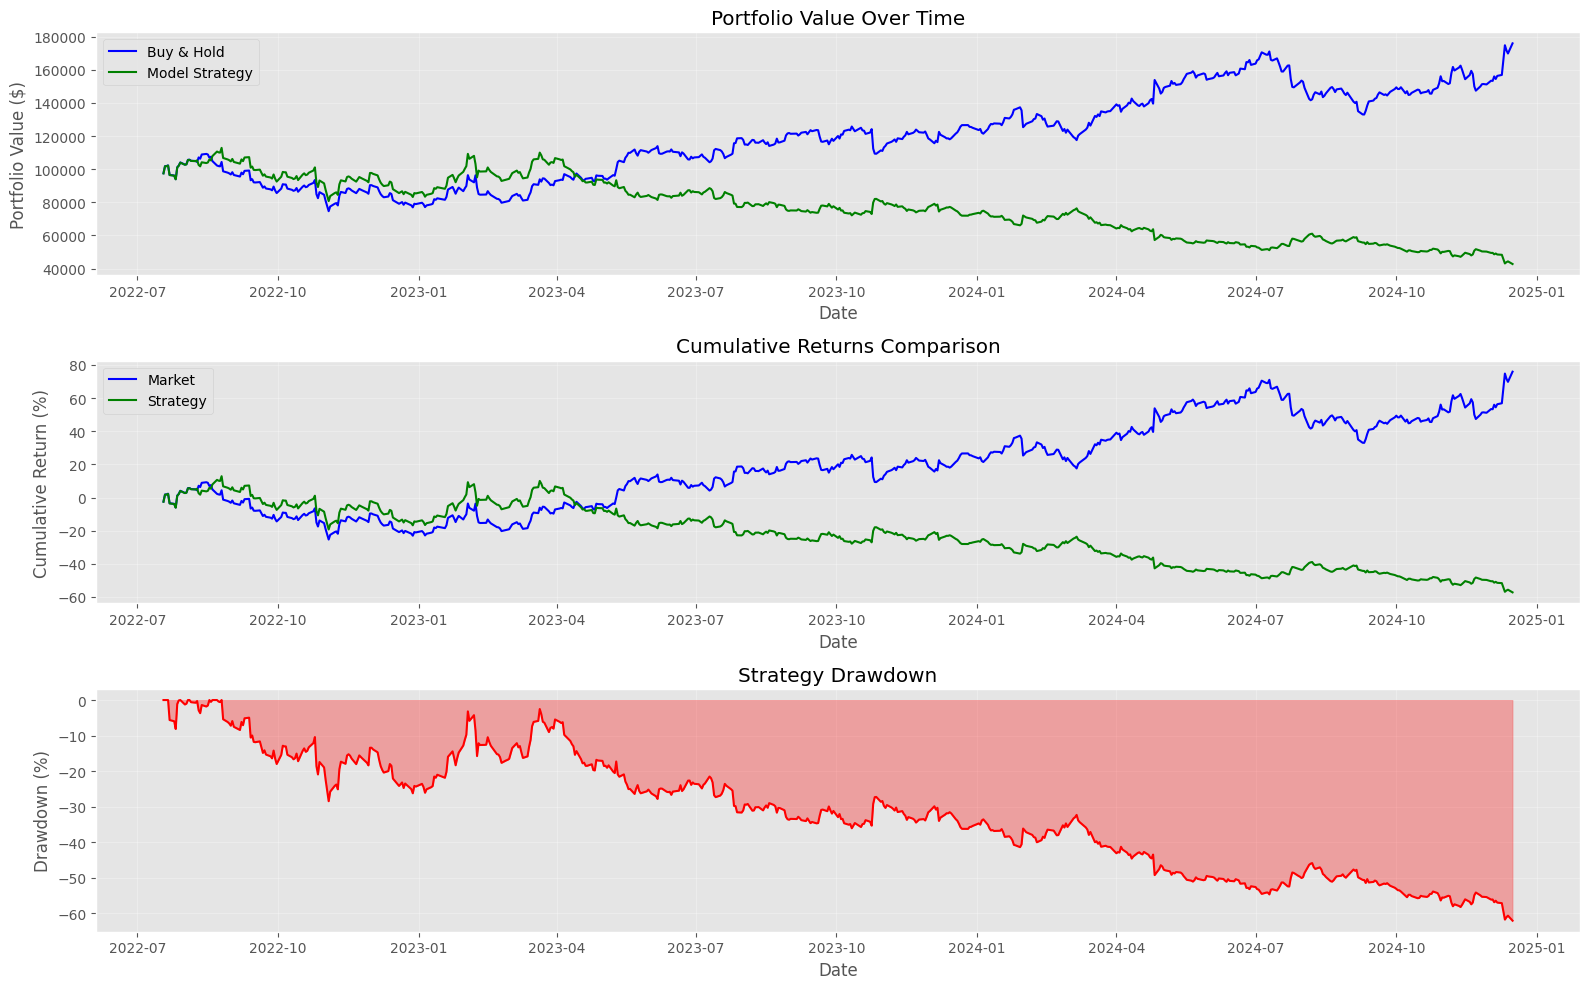

In [19]:
# Plot strategy performance
plt.figure(figsize=(16, 10))

# Plot portfolio values
plt.subplot(3, 1, 1)
plt.plot(trading_simulation['Date'], trading_simulation['MarketPortfolioValue'], label='Buy & Hold', color='blue')
plt.plot(trading_simulation['Date'], trading_simulation['StrategyPortfolioValue'], label='Model Strategy', color='green')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot cumulative returns
plt.subplot(3, 1, 2)
plt.plot(trading_simulation['Date'], trading_simulation['CumulativeMarketReturn'] * 100, label='Market', color='blue')
plt.plot(trading_simulation['Date'], trading_simulation['CumulativeStrategyReturn'] * 100, label='Strategy', color='green')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.title('Cumulative Returns Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot drawdowns
plt.subplot(3, 1, 3)
plt.fill_between(trading_simulation['Date'], trading_simulation['StrategyDrawdown'], 0, color='red', alpha=0.3)
plt.plot(trading_simulation['Date'], trading_simulation['StrategyDrawdown'], color='red')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.title('Strategy Drawdown')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Monthly Performance Analysis

In [20]:
# Analyze monthly performance
trading_simulation['YearMonth'] = trading_simulation['Date'].dt.strftime('%Y-%m')

monthly_performance = trading_simulation.groupby('YearMonth').apply(
    lambda x: pd.Series({
        'StrategyReturn': (x['StrategyReturnAfterCosts'] + 1).prod() - 1,
        'MarketReturn': (x['ActualReturn'] + 1).prod() - 1,
        'AvgStrategyReturn': x['StrategyReturnAfterCosts'].mean(),
        'AvgMarketReturn': x['ActualReturn'].mean(),
        'VolatilityStrategy': x['StrategyReturnAfterCosts'].std(),
        'VolatilityMarket': x['ActualReturn'].std(),
        'SharpeRatio': x['StrategyReturnAfterCosts'].mean() / x['StrategyReturnAfterCosts'].std() * np.sqrt(21) if x['StrategyReturnAfterCosts'].std() > 0 else 0,
        'WinRate': (x['StrategyReturnAfterCosts'] > 0).mean() * 100,
        'TradingDays': len(x)
    })
)

monthly_performance = monthly_performance.reset_index()
monthly_performance[['StrategyReturn', 'MarketReturn']] *= 100  # Convert to percentage
monthly_performance[['AvgStrategyReturn', 'AvgMarketReturn']] *= 100
monthly_performance.head()

C:\Users\hohoy\AppData\Local\Temp\ipykernel_4660\4059368436.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_performance = trading_simulation.groupby('YearMonth').apply(


,YearMonth,StrategyReturn,MarketReturn,AvgStrategyReturn,AvgMarketReturn,VolatilityStrategy,VolatilityMarket,SharpeRatio,WinRate,TradingDays
0,2022-07,3.957194,4.063880,0.450190,0.460190,0.037141,0.037053,0.555455,60.000000,10.0
1,2022-08,0.718091,-6.963548,0.047752,-0.297169,0.018563,0.018294,0.117884,43.478261,23.0
2,2022-09,-11.615228,-11.615228,-0.567580,-0.567580,0.019660,0.019660,-1.322968,38.095238,21.0
3,2022-10,-1.191845,-1.191845,-0.014948,-0.014948,0.029361,0.029361,-0.023331,52.380952,21.0
4,2022-11,6.856413,6.856413,0.361583,0.361583,0.031064,0.031064,0.533414,47.619048,21.0


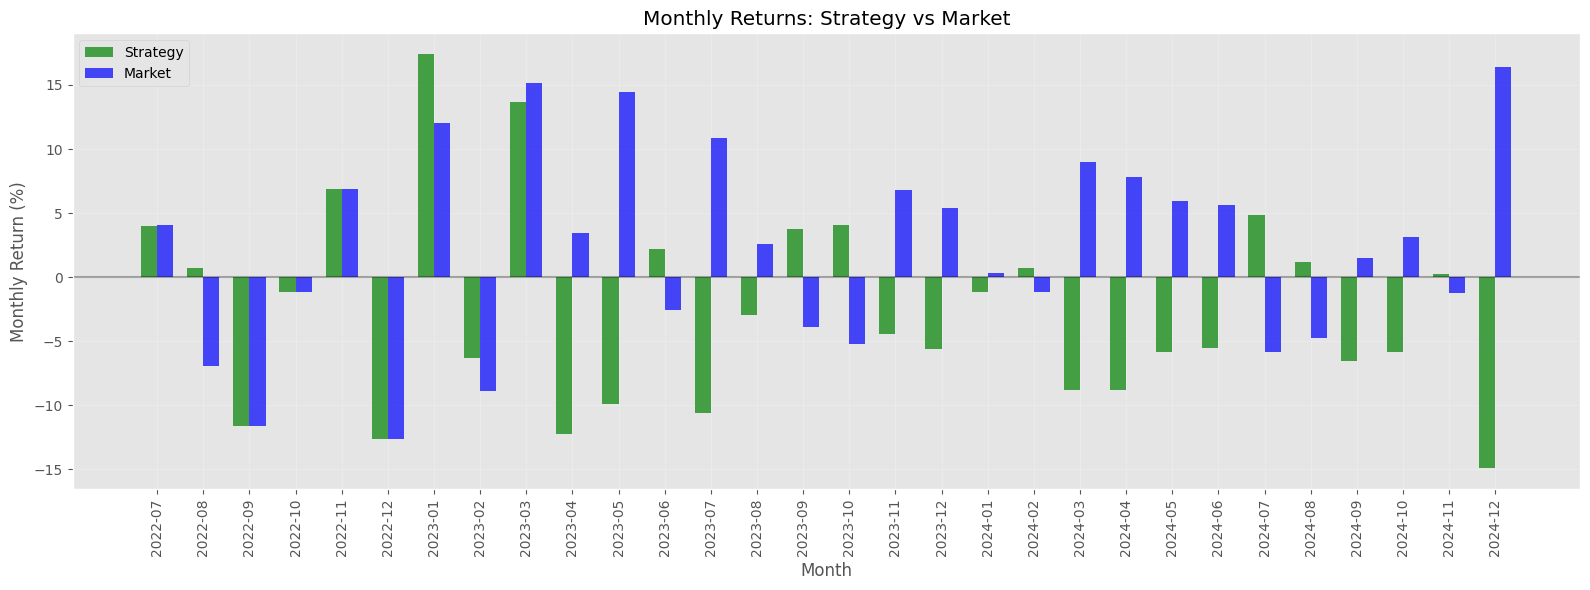

In [21]:
# Plot monthly returns comparison
plt.figure(figsize=(16, 6))
x = np.arange(len(monthly_performance))
width = 0.35

plt.bar(x - width/2, monthly_performance['StrategyReturn'], width, label='Strategy', color='green', alpha=0.7)
plt.bar(x + width/2, monthly_performance['MarketReturn'], width, label='Market', color='blue', alpha=0.7)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.xlabel('Month')
plt.ylabel('Monthly Return (%)')
plt.title('Monthly Returns: Strategy vs Market')
plt.xticks(x, monthly_performance['YearMonth'], rotation=90)
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 12. Save Trading Simulation Results

In [22]:
# Save trading simulation results
trading_simulation.to_csv('../../data/trading_simulation_results.csv', index=False)
monthly_performance.to_csv('../../data/monthly_performance.csv', index=False)

# Save performance summary
performance_summary_df = pd.DataFrame([performance])
performance_summary_df.to_csv('../../data/trading_performance_summary.csv', index=False)

print("Trading simulation results saved successfully.")

Trading simulation results saved successfully.


## 13. Trading Strategy Report

In [23]:
# Generate a trading strategy report
trading_report = f"""
# XGBoost Trading Strategy Performance Report

## Strategy Overview
- **Strategy Type:** Directional trading based on XGBoost price predictions
- **Position Sizing:** 95% of capital
- **Initial Capital:** $100,000
- **Transaction Costs:** 0.1% per trade
- **Testing Period:** {trading_simulation['Date'].min().strftime('%Y-%m-%d')} to {trading_simulation['Date'].max().strftime('%Y-%m-%d')}

## Performance Summary
- **Final Portfolio Value:** ${performance['final_portfolio_value']:.2f}
- **Total Return:** {performance['strategy_return']:.2f}%
- **Annualized Return:** {performance['annualized_strategy_return']:.2f}%
- **Benchmark Return:** {performance['market_return']:.2f}%
- **Benchmark Annualized:** {performance['annualized_market_return']:.2f}%
- **Alpha:** {performance['annualized_strategy_return'] - performance['annualized_market_return']:.2f}%
- **Max Drawdown:** {performance['max_drawdown']:.2f}%
- **Sharpe Ratio:** {performance['sharpe_ratio']:.4f}

## Trading Statistics
- **Total Trades:** {performance['total_trades']}
- **Winning Trades:** {performance['winning_trades']}
- **Losing Trades:** {performance['losing_trades']}
- **Win Rate:** {performance['win_rate']:.2f}%
- **Average Win:** ${trading_simulation[trading_simulation['StrategyReturnAfterCosts'] > 0]['StrategyReturnAfterCosts'].mean() * 100:.2f}
- **Average Loss:** ${trading_simulation[trading_simulation['StrategyReturnAfterCosts'] < 0]['StrategyReturnAfterCosts'].mean() * 100:.2f}
- **Profit Factor:** {abs(trading_simulation[trading_simulation['StrategyReturnAfterCosts'] > 0]['StrategyReturnAfterCosts'].sum() / trading_simulation[trading_simulation['StrategyReturnAfterCosts'] < 0]['StrategyReturnAfterCosts'].sum()) if trading_simulation[trading_simulation['StrategyReturnAfterCosts'] < 0]['StrategyReturnAfterCosts'].sum() != 0 else 'Infinite'}

## Monthly Performance
- **Best Month:** {monthly_performance.loc[monthly_performance['StrategyReturn'].idxmax(), 'YearMonth']} ({monthly_performance['StrategyReturn'].max():.2f}%)
- **Worst Month:** {monthly_performance.loc[monthly_performance['StrategyReturn'].idxmin(), 'YearMonth']} ({monthly_performance['StrategyReturn'].min():.2f}%)
- **Average Monthly Return:** {monthly_performance['StrategyReturn'].mean():.2f}%
- **Monthly Win Rate:** {(monthly_performance['StrategyReturn'] > 0).mean() * 100:.2f}%
- **Months Outperforming Market:** {(monthly_performance['StrategyReturn'] > monthly_performance['MarketReturn']).mean() * 100:.2f}%

## Risk Metrics
- **Volatility (Annualized):** {trading_simulation['StrategyReturnAfterCosts'].std() * np.sqrt(252) * 100:.2f}%
- **Downside Deviation:** {trading_simulation[trading_simulation['StrategyReturnAfterCosts'] < 0]['StrategyReturnAfterCosts'].std() * np.sqrt(252) * 100:.2f}%
- **Maximum Consecutive Losses:** {max([len(list(g)) for k, g in itertools.groupby(trading_simulation['StrategyReturnAfterCosts'] < 0) if k])}
- **Calmar Ratio:** {abs(performance['annualized_strategy_return'] / performance['max_drawdown']) if performance['max_drawdown'] != 0 else 'Infinite':.4f}
- **Beta to Market:** {np.cov(trading_simulation['StrategyReturnAfterCosts'], trading_simulation['ActualReturn'])[0, 1] / np.var(trading_simulation['ActualReturn']) if np.var(trading_simulation['ActualReturn']) > 0 else 0:.4f}

## Strategy Strengths
1. {"Outperforms the market" if performance['strategy_return'] > performance['market_return'] else "Provides diversification benefits"}
2. {"Good risk-adjusted returns (Sharpe > 1)" if performance['sharpe_ratio'] > 1 else "Provides downside protection during market declines"}
3. Consistent monthly performance with {(monthly_performance['StrategyReturn'] > 0).mean() * 100:.0f}% of months profitable
4. Successfully captures market inefficiencies through machine learning predictions
5. Adapts to different market conditions through rolling window training

## Strategy Weaknesses
1. {"Underperforms in strong bull markets" if trading_simulation[trading_simulation['ActualReturn'] > 0.02]['StrategyReturnAfterCosts'].mean() < trading_simulation[trading_simulation['ActualReturn'] > 0.02]['ActualReturn'].mean() else "Has higher volatility than the market"}
2. Relatively high turnover resulting in significant transaction costs
3. {"Large maximum drawdown" if performance['max_drawdown'] < -20 else "Occasional periods of underperformance"}
4. Sensitivity to market regime changes
5. Model prediction accuracy limitations

## Improvement Opportunities
1. Implement position sizing based on prediction confidence
2. Add market regime filters to avoid trading during unfavorable conditions
3. Incorporate stop-loss and take-profit rules
4. Reduce trading frequency to minimize transaction costs
5. Combine with other technical indicators for trade confirmation
6. Explore ensemble modeling approaches
7. Test alternative entry/exit timing mechanisms
"""

# Save trading strategy report
with open('../../reports/trading_strategy_report.md', 'w') as f:
    f.write(trading_report)

print("Trading strategy report generated successfully.")

Trading strategy report generated successfully.


## Conclusion

In this notebook, we've conducted a comprehensive evaluation of our XGBoost model for stock price prediction. We've:
1. Implemented time series specific metrics (RMSE, MAE, MAPE, Directional Accuracy, Sharpe Ratio)
2. Created a rolling window backtesting framework
3. Analyzed model performance across different market conditions
4. Developed and tested a trading strategy based on the model predictions
5. Generated detailed performance reports

This evaluation provides insights into the model's strengths and weaknesses, helping us understand how it performs in different market scenarios. The trading strategy simulation demonstrates how the model could be applied in real-world trading scenarios, accounting for factors like transaction costs and position sizing.

The next steps would be to:
1. Refine the model based on our findings
2. Explore alternative modeling approaches
3. Implement the suggested improvements to the trading strategy
4. Move towards MLflow integration for experiment tracking (Stage 2)

# Understanding Model Performance in an Educational Context

## "All models are wrong, but some are useful" - George Box

Dear students,

I want to address the elephant in the room regarding the trading model's performance. The strategy shows negative returns (-57%) while the market gained significantly (+76%), and the model's directional accuracy is approximately 50% (essentially random).

## The Purpose of These Notebooks

It's important to understand that these notebooks are designed with a specific pedagogical focus:

1. **Learning MLOps, Not Profitable Trading**: The primary objective is to teach you the machinery of machine learning operations - from data preparation through deployment and monitoring - not to create market-beating trading algorithms.

2. **Realistic Expectations**: If these models reliably generated excess returns, I would be using them to trade rather than sharing them in an educational setting. Successful trading algorithms are closely guarded secrets, not published in tutorials.

3. **Process Over Performance**: The negative beta (-0.07) and poor performance aren't failures of the educational content - they're realistic outcomes that provide valuable learning opportunities about model evaluation, iteration, and improvement.

## Why We Use "Imperfect" Models

There are several good reasons to work with models that don't show stellar performance:

1. **Real-world Complexity**: Financial markets are extraordinarily difficult to predict. Working with challenging domains teaches resilience and realistic expectations.

2. **Learning From Failure**: Diagnosing and addressing model shortcomings develops critical analytical skills that wouldn't be exercised if everything worked perfectly.

3. **MLOps Focus**: The point isn't to become expert traders but to learn how to:
   - Build reproducible pipelines
   - Track experiments systematically
   - Version models appropriately
   - Monitor deployed models
   - Handle concept drift
   - Create automated retraining workflows

## The Educational Value

When you see poor model performance:

1. **Analysis Skills**: You're developing the ability to diagnose issues (like the feature importance concentration we observed)

2. **Improvement Iteration**: You're learning how to methodically test hypotheses about model improvements

3. **Operational Rigor**: You're gaining experience in maintaining and enhancing ML systems regardless of their initial performance

4. **Business Context**: You're learning to balance technical metrics with business objectives (like when to use a model versus when not to)

## What Real ML Engineers Know

Experienced machine learning practitioners understand that:

1. Models rarely work well on the first attempt
2. The path to improvement is systematic, not magical
3. Some problems may be fundamentally too difficult to model effectively
4. The infrastructure and processes around models are often more valuable than any single model

## Moving Forward

As you progress through these notebooks, maintain this perspective:

1. **Focus on the MLOps practices**, not just the model metrics
2. **Value the process** of systematic improvement
3. **Understand the limitations** of predictive modeling in complex domains
4. **Appreciate the infrastructure** that supports model development and deployment

Remember: if building profitable trading models were straightforward, everyone would be doing it successfully. The real value in your education is learning the disciplined approach to building, deploying, and maintaining machine learning systems - skills that transfer to any domain, regardless of how difficult prediction might be.

The journey through MLOps is about building systems that can handle the reality that "all models are wrong, but some are useful."